In [1]:
from models.brainiac import load_brainiac
import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_brainiac(checkpoint_path="checkpoints/BrainIAC.ckpt", device=device)

Backbone weights loaded!!


In [ ]:
from utils.datasets import create_pd_data_loaders

train_loader, val_loader, test_loader = create_pd_data_loaders(
    data_dir="data/PD", batch_size=8, num_workers=4
)

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")


Training samples: 416
Validation samples: 84
Test samples: 334


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd

# Set model to evaluation mode
model.eval()


def extract_embeddings(data_loader, dataset_name):
    """Extract embeddings from a dataset using the new PDDataset format."""
    embeddings = []
    metadata = []

    print(f"Extracting embeddings from {dataset_name}...")
    with torch.no_grad():
        for i in range(len(data_loader.dataset)):
            if i % 50 == 0:
                print(f"Processing sample {i}/{len(data_loader.dataset)}")

            # Load data from PDDataset (returns dictionary with multiple keys)
            sample = data_loader.dataset[i]
            image = sample["image"].unsqueeze(0).to(device)  # Add batch dimension

            # Get embedding from the ViT backbone model
            feature_maps = model(image)

            embedding = feature_maps.flatten()

            embeddings.append(embedding.detach().cpu().numpy())

            # Store metadata from the new PDDataset format
            metadata.append(
                {
                    "disease_status": sample["disease_status"].item(),  # 1=PD, 0=HC
                    "sex": sample["sex"].item(),  # 1=M, 0=F
                    "study": sample["study"].item(),  # Study ID
                    "scanner_type": sample["scanner_type"].item(),  # Scanner type ID
                }
            )

    embeddings = np.array(embeddings)
    print(f"Extracted embeddings shape: {embeddings.shape}")
    print(f"Number of samples: {len(metadata)}")

    return embeddings, metadata


# Extract embeddings for all datasets
train_embeddings, train_metadata = extract_embeddings(train_loader, "training")
val_embeddings, val_metadata = extract_embeddings(val_loader, "validation")
test_embeddings, test_metadata = extract_embeddings(test_loader, "test")

# Combine train and validation for K-NN training
train_val_embeddings = np.vstack([train_embeddings, val_embeddings])
train_val_metadata = train_metadata + val_metadata

print(f"\nCombined train+val embeddings shape: {train_val_embeddings.shape}")
print(f"Combined train+val metadata length: {len(train_val_metadata)}")
print(f"Test embeddings shape: {test_embeddings.shape}")
print(f"Test metadata length: {len(test_metadata)}")


Extracting embeddings from training...
Processing sample 0/416
Processing sample 50/416
Processing sample 100/416
Processing sample 150/416
Processing sample 200/416
Processing sample 250/416
Processing sample 300/416
Processing sample 350/416
Processing sample 400/416
Extracted embeddings shape: (416, 768)
Number of samples: 416
Extracting embeddings from validation...
Processing sample 0/84
Processing sample 50/84
Extracted embeddings shape: (84, 768)
Number of samples: 84
Extracting embeddings from test...
Processing sample 0/334
Processing sample 50/334
Processing sample 100/334
Processing sample 150/334
Processing sample 200/334
Processing sample 250/334
Processing sample 300/334
Extracted embeddings shape: (334, 768)
Number of samples: 334

Combined train+val embeddings shape: (500, 768)
Combined train+val metadata length: 500
Test embeddings shape: (334, 768)
Test metadata length: 334


In [7]:
# K-NN Classification Evaluation
def evaluate_knn_classification(X_train, y_train, X_test, y_test, task_name, k=5):
    """Evaluate K-NN classification performance."""
    print(f"\n=== {task_name.upper()} CLASSIFICATION ===")

    # Train K-NN classifier
    knn = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
    knn.fit(X_train, y_train)

    # Make predictions
    y_pred = knn.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Print results
    print(f"K-NN (k={k}) Accuracy: {accuracy:.4f}")
    print(f"Classification Report:")
    print(classification_report(y_test, y_pred))

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=sorted(np.unique(y_test)),
        yticklabels=sorted(np.unique(y_test)),
    )
    plt.title(f"Confusion Matrix - {task_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return accuracy, y_pred


# Prepare data for classification
# Extract labels for combined train+val (for training K-NN)
train_val_disease = np.array([m["disease_status"] for m in train_val_metadata])
train_val_sex = np.array([m["sex"] for m in train_val_metadata])
train_val_study = np.array([m["study"] for m in train_val_metadata])
train_val_scanner = np.array([m["scanner_type"] for m in train_val_metadata])

# Extract labels for test set (for evaluation)
test_disease = np.array([m["disease_status"] for m in test_metadata])
test_sex = np.array([m["sex"] for m in test_metadata])
test_study = np.array([m["study"] for m in test_metadata])
test_scanner = np.array([m["scanner_type"] for m in test_metadata])

print("Combined Train+Val set label distributions:")
print(f"Disease: {np.bincount(train_val_disease)}")
print(f"Sex: {np.bincount(train_val_sex)}")
print(f"Study: {np.bincount(train_val_study)}")
print(f"Scanner: {np.bincount(train_val_scanner)}")

print("\nTest set label distributions:")
print(f"Disease: {np.bincount(test_disease)}")
print(f"Sex: {np.bincount(test_sex)}")
print(f"Study: {np.bincount(test_study)}")
print(f"Scanner: {np.bincount(test_scanner)}")


Combined Train+Val set label distributions:
Disease: [244 256]
Sex: [212 288]
Study: [ 73 147  67  44  25  27  38  22  57]
Scanner: [ 73   0   0   0   0   0   0   0  25   0   0   0  44 214  57   0  22  38
  27]

Test set label distributions:
Disease: [164 170]
Sex: [141 193]
Study: [48 98 46 31 17 18 24 15 37]
Scanner: [ 48   0   0   0   0   0   0   0  17   0   0   0  31 144  37   0  15  24
  18]



=== DISEASE STATUS CLASSIFICATION ===
K-NN (k=5) Accuracy: 0.5898
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.56      0.57       164
           1       0.59      0.62      0.61       170

    accuracy                           0.59       334
   macro avg       0.59      0.59      0.59       334
weighted avg       0.59      0.59      0.59       334



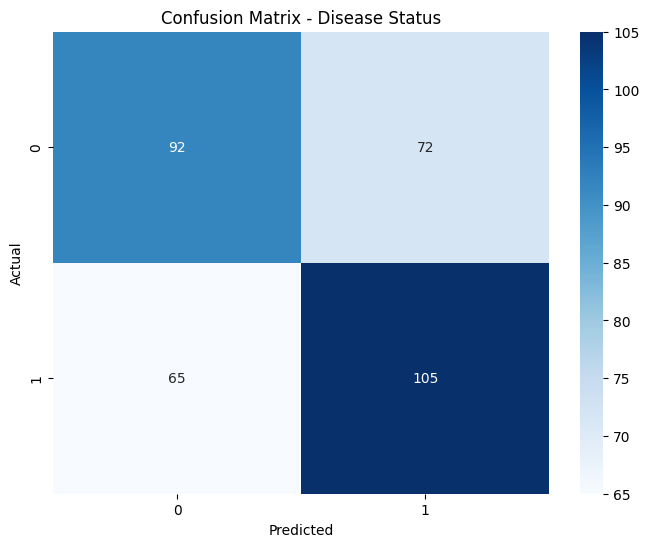


=== SEX CLASSIFICATION ===
K-NN (k=5) Accuracy: 0.4910
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.34      0.36       141
           1       0.56      0.60      0.58       193

    accuracy                           0.49       334
   macro avg       0.47      0.47      0.47       334
weighted avg       0.48      0.49      0.49       334



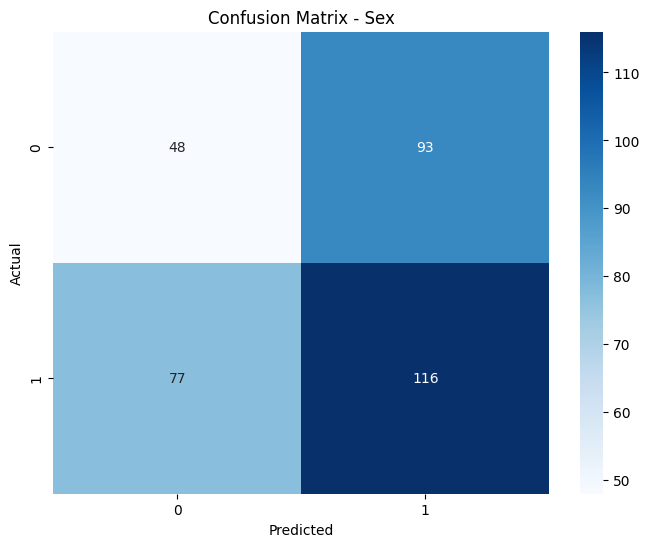


=== STUDY CLASSIFICATION ===
K-NN (k=5) Accuracy: 0.2725
Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.21      0.16        48
           1       0.36      0.56      0.44        98
           2       0.21      0.13      0.16        46
           3       0.15      0.10      0.12        31
           4       0.00      0.00      0.00        17
           5       0.00      0.00      0.00        18
           6       0.33      0.25      0.29        24
           7       0.17      0.07      0.10        15
           8       0.40      0.27      0.32        37

    accuracy                           0.27       334
   macro avg       0.19      0.18      0.18       334
weighted avg       0.24      0.27      0.24       334



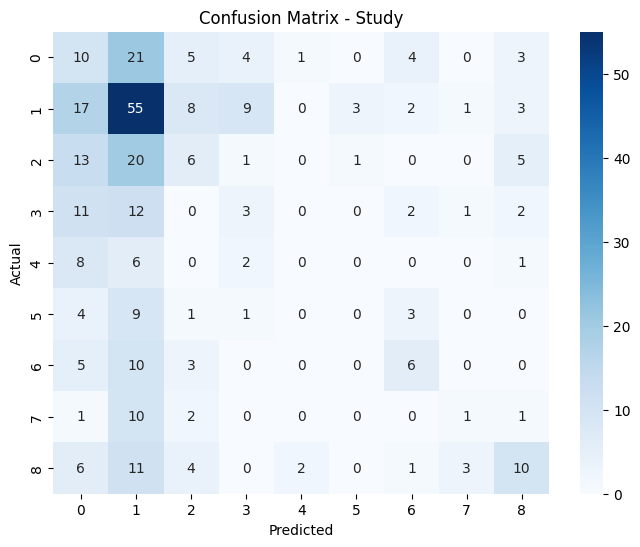


=== SCANNER TYPE CLASSIFICATION ===
K-NN (k=5) Accuracy: 0.3533
Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.10      0.10        48
           8       0.00      0.00      0.00        17
          12       0.12      0.10      0.11        31
          13       0.47      0.67      0.55       144
          14       0.48      0.30      0.37        37
          16       0.00      0.00      0.00        15
          17       0.23      0.12      0.16        24
          18       0.00      0.00      0.00        18

    accuracy                           0.35       334
   macro avg       0.17      0.16      0.16       334
weighted avg       0.29      0.35      0.31       334



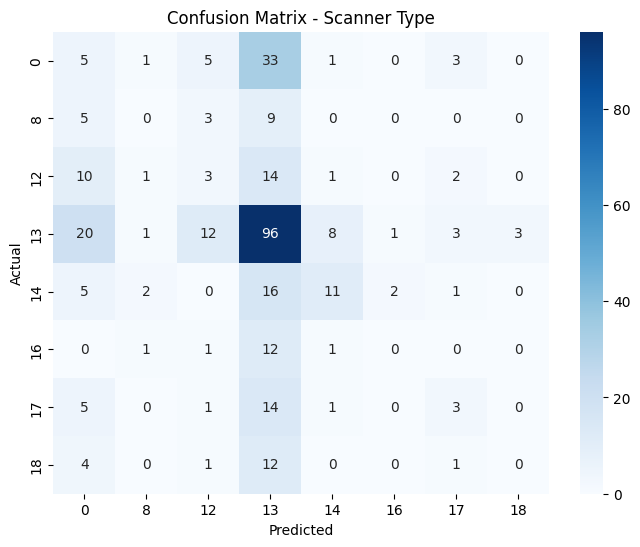

In [8]:
# Run K-NN classification for all tasks
# Train on combined train+val, test on separate test set
results = {}

# Disease Status Classification (PD vs HC)
disease_accuracy, disease_predictions = evaluate_knn_classification(
    train_val_embeddings,
    train_val_disease,
    test_embeddings,
    test_disease,
    "Disease Status",
    k=5,
)
results["Disease Status"] = disease_accuracy

# Sex Classification (Male vs Female)
sex_accuracy, sex_predictions = evaluate_knn_classification(
    train_val_embeddings, train_val_sex, test_embeddings, test_sex, "Sex", k=5
)
results["Sex"] = sex_accuracy

# Study Classification
study_accuracy, study_predictions = evaluate_knn_classification(
    train_val_embeddings, train_val_study, test_embeddings, test_study, "Study", k=5
)
results["Study"] = study_accuracy

# Scanner Type Classification
scanner_accuracy, scanner_predictions = evaluate_knn_classification(
    train_val_embeddings,
    train_val_scanner,
    test_embeddings,
    test_scanner,
    "Scanner Type",
    k=5,
)
results["Scanner Type"] = scanner_accuracy



K-NN CLASSIFICATION RESULTS SUMMARY
Training: Combined Train+Val (500 samples)
Testing: Separate Test Set (334 samples)
Disease Status : 0.5898 (58.98%)
Sex            : 0.4910 (49.10%)
Study          : 0.2725 (27.25%)
Scanner Type   : 0.3533 (35.33%)


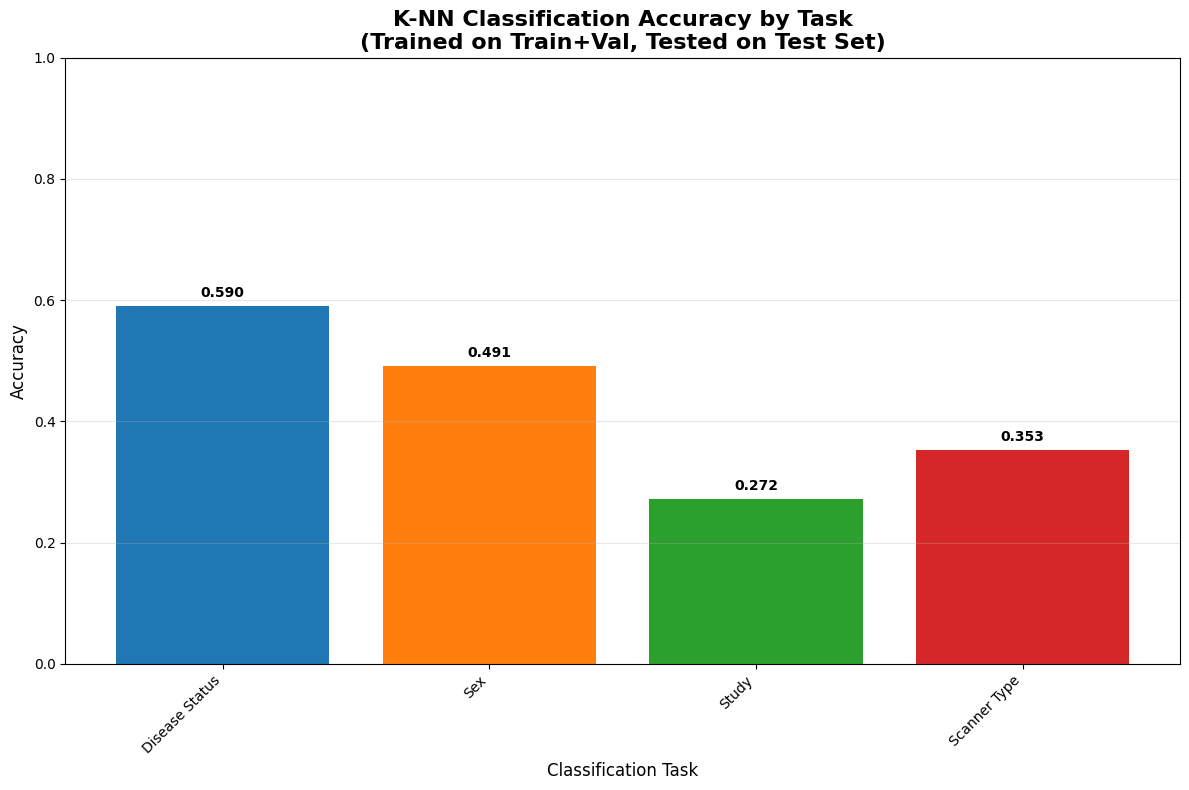


INTERPRETATION
• HIGH accuracy on Disease Status suggests the encoder learned disease-relevant features
• LOW accuracy on Sex indicates the encoder is not overfitting to gender
• HIGH accuracy on Study/Scanner may indicate dataset bias
• IDEAL: High disease accuracy, Low sex/study/scanner accuracy
• This evaluation tests generalization to unseen test data


In [9]:
# Summary of Classification Results
print("\n" + "=" * 80)
print("K-NN CLASSIFICATION RESULTS SUMMARY")
print("=" * 80)
print("Training: Combined Train+Val (500 samples)")
print("Testing: Separate Test Set (334 samples)")
print("=" * 80)

for task, accuracy in results.items():
    print(f"{task:15}: {accuracy:.4f} ({accuracy * 100:.2f}%)")

# Create a bar plot of results
plt.figure(figsize=(12, 8))
tasks = list(results.keys())
accuracies = list(results.values())

bars = plt.bar(tasks, accuracies, color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
plt.title(
    "K-NN Classification Accuracy by Task\n(Trained on Train+Val, Tested on Test Set)",
    fontsize=16,
    fontweight="bold",
)
plt.xlabel("Classification Task", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1)
plt.grid(axis="y", alpha=0.3)

# Add value labels on bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{accuracy:.3f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Interpretation
print("\n" + "=" * 80)
print("INTERPRETATION")
print("=" * 80)
print(
    "• HIGH accuracy on Disease Status suggests the encoder learned disease-relevant features"
)
print("• LOW accuracy on Sex indicates the encoder is not overfitting to gender")
print("• HIGH accuracy on Study/Scanner may indicate dataset bias")
print("• IDEAL: High disease accuracy, Low sex/study/scanner accuracy")
print("• This evaluation tests generalization to unseen test data")
print("=" * 80)


In [10]:
# t-SNE Visualization of Embeddings
print("Creating t-SNE visualization...")

# Combine all embeddings for comprehensive t-SNE visualization
all_embeddings = np.vstack([train_embeddings, val_embeddings, test_embeddings])
all_metadata = train_metadata + val_metadata + test_metadata

# Create t-SNE embedding
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Create DataFrame for plotting
df_tsne = pd.DataFrame(
    {
        "x": embeddings_2d[:, 0],
        "y": embeddings_2d[:, 1],
        "disease_status": [m["disease_status"] for m in all_metadata],
        "sex": [m["sex"] for m in all_metadata],
        "study": [m["study"] for m in all_metadata],
        "scanner_type": [m["scanner_type"] for m in all_metadata],
        "dataset": ["Train"] * len(train_metadata)
        + ["Validation"] * len(val_metadata)
        + ["Test"] * len(test_metadata),
    }
)

# Convert labels to readable strings
df_tsne["disease_label"] = df_tsne["disease_status"].map(
    {0: "Healthy Control", 1: "Parkinson's Disease"}
)
df_tsne["sex_label"] = df_tsne["sex"].map({0: "Female", 1: "Male"})

print("t-SNE computation completed!")
print(f"Total samples in t-SNE: {len(df_tsne)}")
print(
    f"Dataset split: Train={len(train_metadata)}, Val={len(val_metadata)}, Test={len(test_metadata)}"
)


Creating t-SNE visualization...


/data/Software/.conda/envs/fomo/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE computation completed!
Total samples in t-SNE: 834
Dataset split: Train=416, Val=84, Test=334


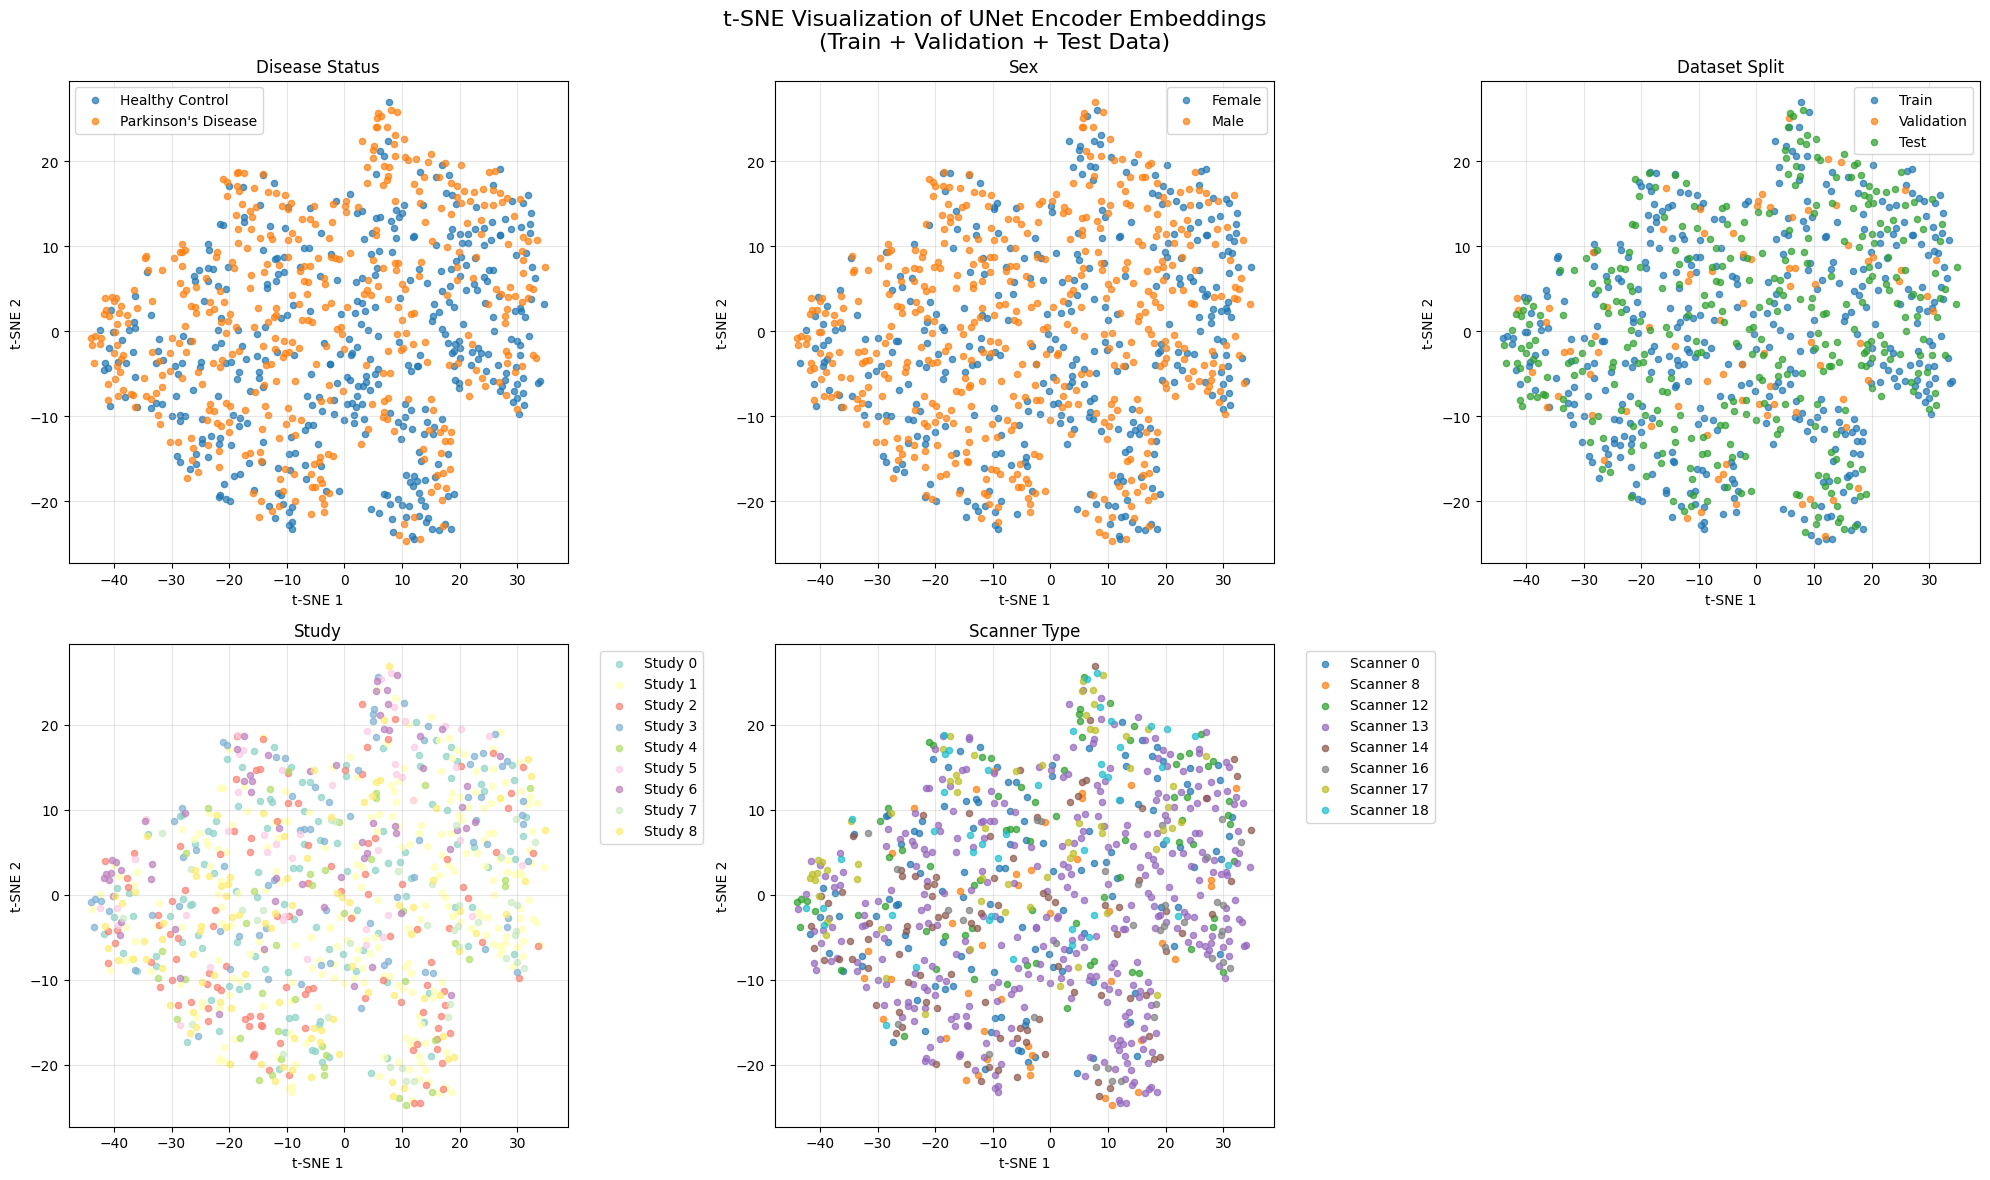

In [11]:
# Create t-SNE visualization plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle(
    "t-SNE Visualization of UNet Encoder Embeddings\n(Train + Validation + Test Data)",
    fontsize=16,
)

# Plot 1: Disease Status
ax1 = axes[0, 0]
for status, label in [(0, "Healthy Control"), (1, "Parkinson's Disease")]:
    mask = df_tsne["disease_status"] == status
    ax1.scatter(df_tsne[mask]["x"], df_tsne[mask]["y"], label=label, alpha=0.7, s=20)
ax1.set_title("Disease Status")
ax1.set_xlabel("t-SNE 1")
ax1.set_ylabel("t-SNE 2")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Sex
ax2 = axes[0, 1]
for sex, label in [(0, "Female"), (1, "Male")]:
    mask = df_tsne["sex"] == sex
    ax2.scatter(df_tsne[mask]["x"], df_tsne[mask]["y"], label=label, alpha=0.7, s=20)
ax2.set_title("Sex")
ax2.set_xlabel("t-SNE 1")
ax2.set_ylabel("t-SNE 2")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Dataset Split
ax3 = axes[0, 2]
for dataset, color in [
    ("Train", "#1f77b4"),
    ("Validation", "#ff7f0e"),
    ("Test", "#2ca02c"),
]:
    mask = df_tsne["dataset"] == dataset
    ax3.scatter(
        df_tsne[mask]["x"],
        df_tsne[mask]["y"],
        label=dataset,
        alpha=0.7,
        s=20,
        color=color,
    )
ax3.set_title("Dataset Split")
ax3.set_xlabel("t-SNE 1")
ax3.set_ylabel("t-SNE 2")
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Study
ax4 = axes[1, 0]
unique_studies = sorted(df_tsne["study"].unique())
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_studies)))
for i, study in enumerate(unique_studies):
    mask = df_tsne["study"] == study
    ax4.scatter(
        df_tsne[mask]["x"],
        df_tsne[mask]["y"],
        label=f"Study {study}",
        alpha=0.7,
        s=20,
        color=colors[i],
    )
ax4.set_title("Study")
ax4.set_xlabel("t-SNE 1")
ax4.set_ylabel("t-SNE 2")
ax4.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax4.grid(True, alpha=0.3)

# Plot 5: Scanner Type
ax5 = axes[1, 1]
unique_scanners = sorted(df_tsne["scanner_type"].unique())
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_scanners)))
for i, scanner in enumerate(unique_scanners):
    mask = df_tsne["scanner_type"] == scanner
    ax5.scatter(
        df_tsne[mask]["x"],
        df_tsne[mask]["y"],
        label=f"Scanner {scanner}",
        alpha=0.7,
        s=20,
        color=colors[i],
    )
ax5.set_title("Scanner Type")
ax5.set_xlabel("t-SNE 1")
ax5.set_ylabel("t-SNE 2")
ax5.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax5.grid(True, alpha=0.3)

# Remove the empty subplot
axes[1, 2].remove()

plt.tight_layout()
plt.show()


In [10]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np


# Linear Probe Class
class LinearProbe(nn.Module):
    def __init__(self, input_dim, num_classes, dropout_rate=0.1):
        super(LinearProbe, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        return self.classifier(x)


def train_linear_probe(
    X_train,
    y_train,
    X_val,
    y_val,
    task_name,
    num_classes,
    num_epochs=100,
    batch_size=32,
    learning_rate=0.001,
    patience=10,
):
    """
    Train a linear probe with early stopping based on validation performance.
    """
    print(f"\n{'=' * 60}")
    print(f"TRAINING LINEAR PROBE: {task_name.upper()}")
    print(f"{'=' * 60}")
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Number of classes: {num_classes}")

    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.LongTensor(y_val)

    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, and optimizer
    model = LinearProbe(X_train.shape[1], num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training history
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_acc = 0
    best_model_state = None
    patience_counter = 0

    print(f"\nStarting training for {num_epochs} epochs...")
    print(f"Early stopping patience: {patience}")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        # Store history
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        # Print progress
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(
                f"Epoch {epoch:3d}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
                f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, Best Val Acc={best_val_acc:.4f}"
            )

        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch} (patience={patience})")
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print(f"\nBest validation accuracy: {best_val_acc:.4f}")

    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss curves
    ax1.plot(train_losses, label="Train Loss", alpha=0.8)
    ax1.plot(val_losses, label="Validation Loss", alpha=0.8)
    ax1.set_title(f"{task_name} - Training and Validation Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy curves
    ax2.plot(train_accuracies, label="Train Accuracy", alpha=0.8)
    ax2.plot(val_accuracies, label="Validation Accuracy", alpha=0.8)
    ax2.axhline(
        y=best_val_acc,
        color="r",
        linestyle="--",
        alpha=0.7,
        label=f"Best Val Acc: {best_val_acc:.4f}",
    )
    ax2.set_title(f"{task_name} - Training and Validation Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return (
        model,
        best_val_acc,
        train_losses,
        val_losses,
        train_accuracies,
        val_accuracies,
    )


Starting Linear Probe Training...
Data Split Strategy:
- Training: Train embeddings (416 samples)
- Validation: Validation embeddings (84 samples)
- Testing: Test embeddings (334 samples)

TASK 1: DISEASE STATUS CLASSIFICATION

TRAINING LINEAR PROBE: DISEASE STATUS
Training samples: 416
Validation samples: 84
Number of classes: 2

Starting training for 100 epochs...
Early stopping patience: 15
Epoch   0: Train Loss=0.6949, Train Acc=0.4904, Val Loss=0.6933, Val Acc=0.4762, Best Val Acc=0.4762
Epoch  10: Train Loss=0.6925, Train Acc=0.5144, Val Loss=0.6901, Val Acc=0.5238, Best Val Acc=0.6190
Epoch  20: Train Loss=0.6769, Train Acc=0.5649, Val Loss=0.6800, Val Acc=0.5833, Best Val Acc=0.6310
Epoch  30: Train Loss=0.6654, Train Acc=0.5889, Val Loss=0.6713, Val Acc=0.6429, Best Val Acc=0.6429
Epoch  40: Train Loss=0.6559, Train Acc=0.6082, Val Loss=0.6611, Val Acc=0.6071, Best Val Acc=0.6667
Epoch  50: Train Loss=0.6527, Train Acc=0.6154, Val Loss=0.6508, Val Acc=0.6310, Best Val Acc=0.66

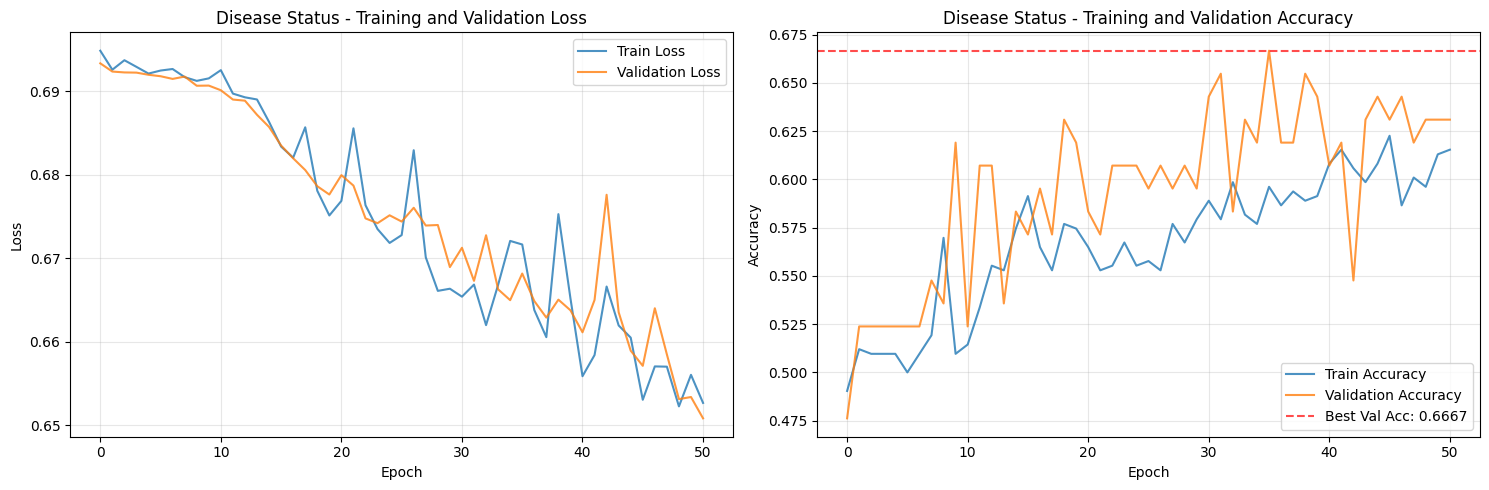


TASK 2: SEX CLASSIFICATION

TRAINING LINEAR PROBE: SEX
Training samples: 416
Validation samples: 84
Number of classes: 2

Starting training for 100 epochs...
Early stopping patience: 15
Epoch   0: Train Loss=0.6843, Train Acc=0.5745, Val Loss=0.6786, Val Acc=0.5833, Best Val Acc=0.5833
Epoch  10: Train Loss=0.6825, Train Acc=0.5745, Val Loss=0.6771, Val Acc=0.5833, Best Val Acc=0.5833

Early stopping at epoch 15 (patience=15)

Best validation accuracy: 0.5833


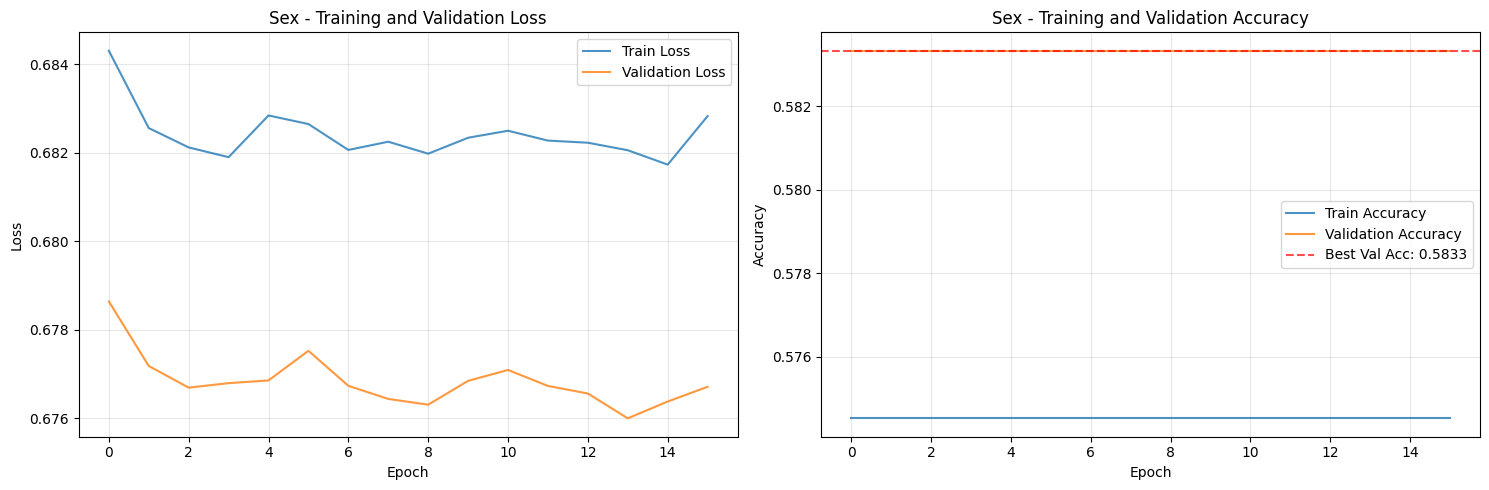


TASK 3: STUDY CLASSIFICATION
Number of unique studies: 9

TRAINING LINEAR PROBE: STUDY
Training samples: 416
Validation samples: 84
Number of classes: 9

Starting training for 100 epochs...
Early stopping patience: 15
Epoch   0: Train Loss=2.1892, Train Acc=0.0913, Val Loss=2.1653, Val Acc=0.1429, Best Val Acc=0.1429
Epoch  10: Train Loss=2.0123, Train Acc=0.2933, Val Loss=2.0346, Val Acc=0.2976, Best Val Acc=0.2976

Early stopping at epoch 16 (patience=15)

Best validation accuracy: 0.2976


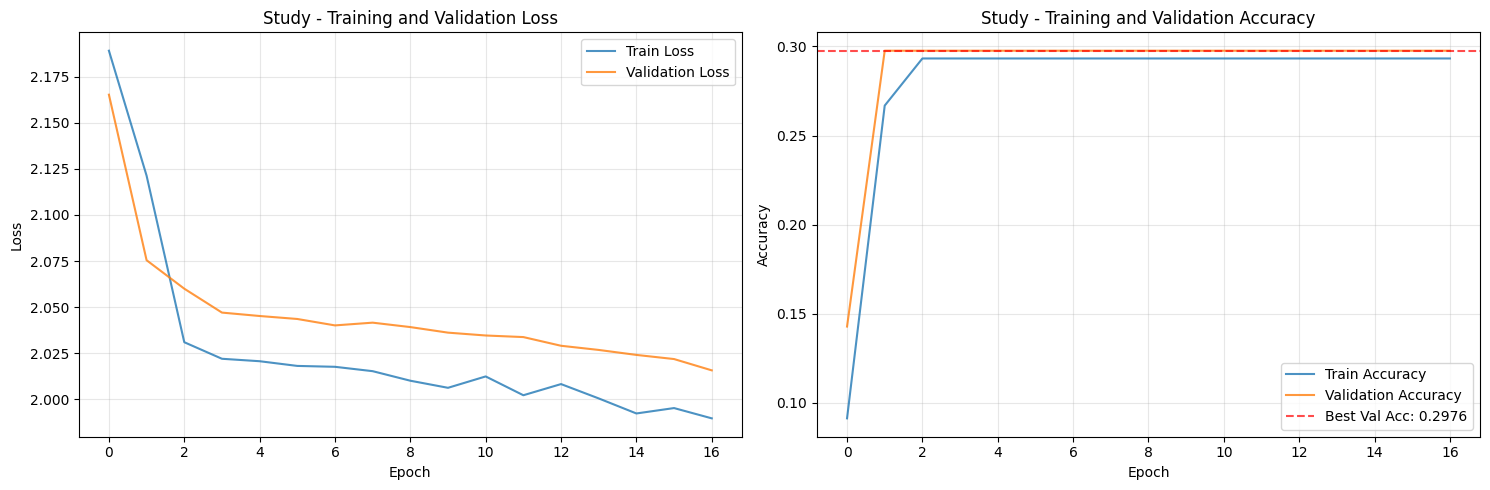


TASK 4: SCANNER TYPE CLASSIFICATION
Number of unique scanner types: 8

TRAINING LINEAR PROBE: SCANNER TYPE
Training samples: 416
Validation samples: 84
Number of classes: 8

Starting training for 100 epochs...
Early stopping patience: 15
Epoch   0: Train Loss=2.0427, Train Acc=0.3558, Val Loss=1.9865, Val Acc=0.4167, Best Val Acc=0.4167
Epoch  10: Train Loss=1.7365, Train Acc=0.4303, Val Loss=1.7996, Val Acc=0.4167, Best Val Acc=0.4167

Early stopping at epoch 15 (patience=15)

Best validation accuracy: 0.4167


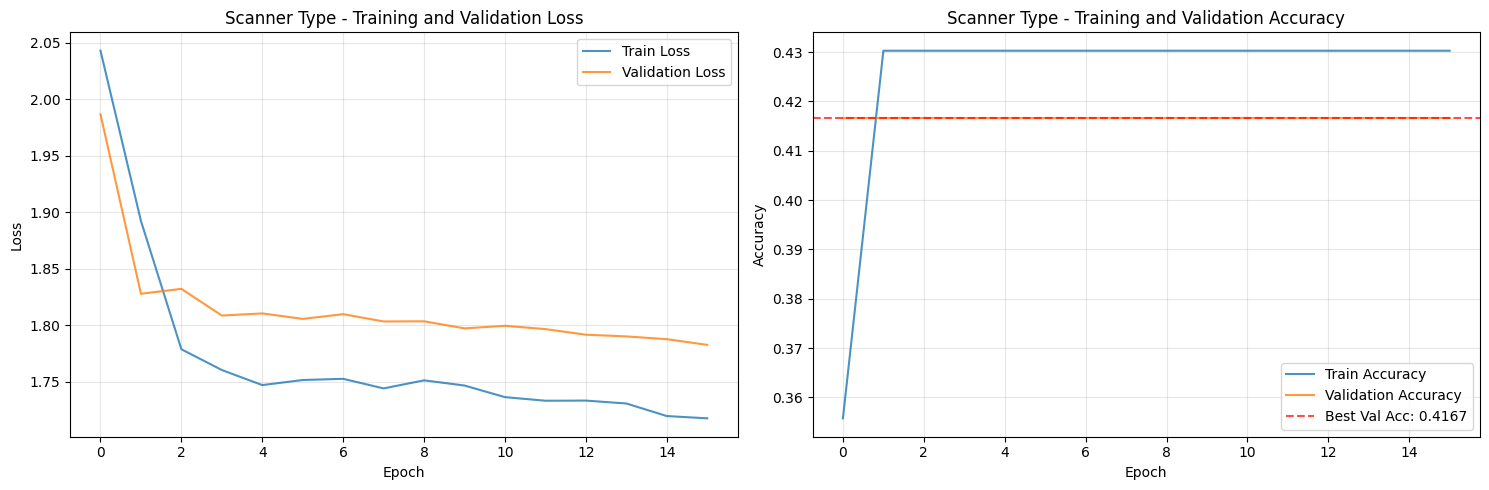

In [11]:
# Train Linear Probes for All Classification Tasks
print("Starting Linear Probe Training...")
print("=" * 80)
print("Data Split Strategy:")
print("- Training: Train embeddings (416 samples)")
print("- Validation: Validation embeddings (84 samples)")
print("- Testing: Test embeddings (334 samples)")
print("=" * 80)

# Use proper data splits: train for training, val for validation, test for testing
X_train_probe = train_embeddings
X_val_probe = val_embeddings
X_test_probe = test_embeddings

# Extract labels for each split
y_train_disease = np.array([m["disease_status"] for m in train_metadata])
y_val_disease = np.array([m["disease_status"] for m in val_metadata])
y_test_disease = np.array([m["disease_status"] for m in test_metadata])

y_train_sex = np.array([m["sex"] for m in train_metadata])
y_val_sex = np.array([m["sex"] for m in val_metadata])
y_test_sex = np.array([m["sex"] for m in test_metadata])

y_train_study = np.array([m["study"] for m in train_metadata])
y_val_study = np.array([m["study"] for m in val_metadata])
y_test_study = np.array([m["study"] for m in test_metadata])

y_train_scanner = np.array([m["scanner_type"] for m in train_metadata])
y_val_scanner = np.array([m["scanner_type"] for m in val_metadata])
y_test_scanner = np.array([m["scanner_type"] for m in test_metadata])

# Train linear probes for each task
probe_results = {}
trained_models = {}

# 1. Disease Status Classification (Binary)
print("\n" + "=" * 60)
print("TASK 1: DISEASE STATUS CLASSIFICATION")
print("=" * 60)

disease_model, disease_val_acc, _, _, _, _ = train_linear_probe(
    X_train_probe,
    y_train_disease,
    X_val_probe,
    y_val_disease,
    "Disease Status",
    num_classes=2,
    num_epochs=100,
    patience=15,
)
probe_results["Disease Status"] = disease_val_acc
trained_models["Disease Status"] = disease_model

# 2. Sex Classification (Binary)
print("\n" + "=" * 60)
print("TASK 2: SEX CLASSIFICATION")
print("=" * 60)

sex_model, sex_val_acc, _, _, _, _ = train_linear_probe(
    X_train_probe,
    y_train_sex,
    X_val_probe,
    y_val_sex,
    "Sex",
    num_classes=2,
    num_epochs=100,
    patience=15,
)
probe_results["Sex"] = sex_val_acc
trained_models["Sex"] = sex_model

# 3. Study Classification (Multi-class)
print("\n" + "=" * 60)
print("TASK 3: STUDY CLASSIFICATION")
print("=" * 60)

# Get number of unique studies
num_studies = len(np.unique(np.concatenate([y_train_study, y_val_study, y_test_study])))
print(f"Number of unique studies: {num_studies}")

study_model, study_val_acc, _, _, _, _ = train_linear_probe(
    X_train_probe,
    y_train_study,
    X_val_probe,
    y_val_study,
    "Study",
    num_classes=num_studies,
    num_epochs=100,
    patience=15,
)
probe_results["Study"] = study_val_acc
trained_models["Study"] = study_model

# 4. Scanner Type Classification (Multi-class)
print("\n" + "=" * 60)
print("TASK 4: SCANNER TYPE CLASSIFICATION")
print("=" * 60)

# Get number of unique scanner types
num_scanners = len(
    np.unique(np.concatenate([y_train_scanner, y_val_scanner, y_test_scanner]))
)
print(f"Number of unique scanner types: {num_scanners}")

scanner_model, scanner_val_acc, _, _, _, _ = train_linear_probe(
    X_train_probe,
    y_train_scanner,
    X_val_probe,
    y_val_scanner,
    "Scanner Type",
    num_classes=num_scanners,
    num_epochs=100,
    patience=15,
)
probe_results["Scanner Type"] = scanner_val_acc
trained_models["Scanner Type"] = scanner_model


In [12]:
# Evaluate Trained Models and Report Results
def evaluate_model_on_test_set(model, X_test, y_test, task_name):
    """Evaluate trained model on test set."""
    model.eval()
    X_test_tensor = torch.FloatTensor(X_test)

    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        predictions = predicted.numpy()

    accuracy = accuracy_score(y_test, predictions)

    print(f"\n{task_name} - Test Set Evaluation:")
    print(f"Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))

    return accuracy, predictions


# Evaluate all models on proper test set
print("=" * 80)
print("FINAL EVALUATION ON TEST SET")
print("=" * 80)
print(f"Test set size: {len(X_test_probe)} samples")
print("=" * 80)

test_results = {}
all_predictions = {}

# Evaluate each model on the proper test set
for task_name, model in trained_models.items():
    if task_name == "Disease Status":
        test_acc, pred = evaluate_model_on_test_set(
            model, X_test_probe, y_test_disease, task_name
        )
        test_results[task_name] = test_acc
        all_predictions[task_name] = pred
    elif task_name == "Sex":
        test_acc, pred = evaluate_model_on_test_set(
            model, X_test_probe, y_test_sex, task_name
        )
        test_results[task_name] = test_acc
        all_predictions[task_name] = pred
    elif task_name == "Study":
        test_acc, pred = evaluate_model_on_test_set(
            model, X_test_probe, y_test_study, task_name
        )
        test_results[task_name] = test_acc
        all_predictions[task_name] = pred
    elif task_name == "Scanner Type":
        test_acc, pred = evaluate_model_on_test_set(
            model, X_test_probe, y_test_scanner, task_name
        )
        test_results[task_name] = test_acc
        all_predictions[task_name] = pred


FINAL EVALUATION ON TEST SET
Test set size: 334 samples

Disease Status - Test Set Evaluation:
Accuracy: 0.6677 (66.77%)

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.59      0.64       164
           1       0.65      0.74      0.69       170

    accuracy                           0.67       334
   macro avg       0.67      0.67      0.67       334
weighted avg       0.67      0.67      0.67       334


Sex - Test Set Evaluation:
Accuracy: 0.5778 (57.78%)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       141
           1       0.58      1.00      0.73       193

    accuracy                           0.58       334
   macro avg       0.29      0.50      0.37       334
weighted avg       0.33      0.58      0.42       334


Study - Test Set Evaluation:
Accuracy: 0.2934 (29.34%)

Classification Report:
              precision    recall  f1-score

/data/Software/.conda/envs/fomo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/Software/.conda/envs/fomo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/Software/.conda/envs/fomo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",


COMPREHENSIVE LINEAR PROBE RESULTS SUMMARY

RESULTS TABLE:
          Task  Validation Accuracy  Final Test Accuracy   Task Type  Classes
Disease Status               0.6667               0.6677      Binary        2
           Sex               0.5833               0.5778      Binary        2
         Study               0.2976               0.2934 Multi-class        9
  Scanner Type               0.4167               0.4311 Multi-class        8


/tmp/ipykernel_576654/102821585.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(tasks, rotation=45, ha="right")


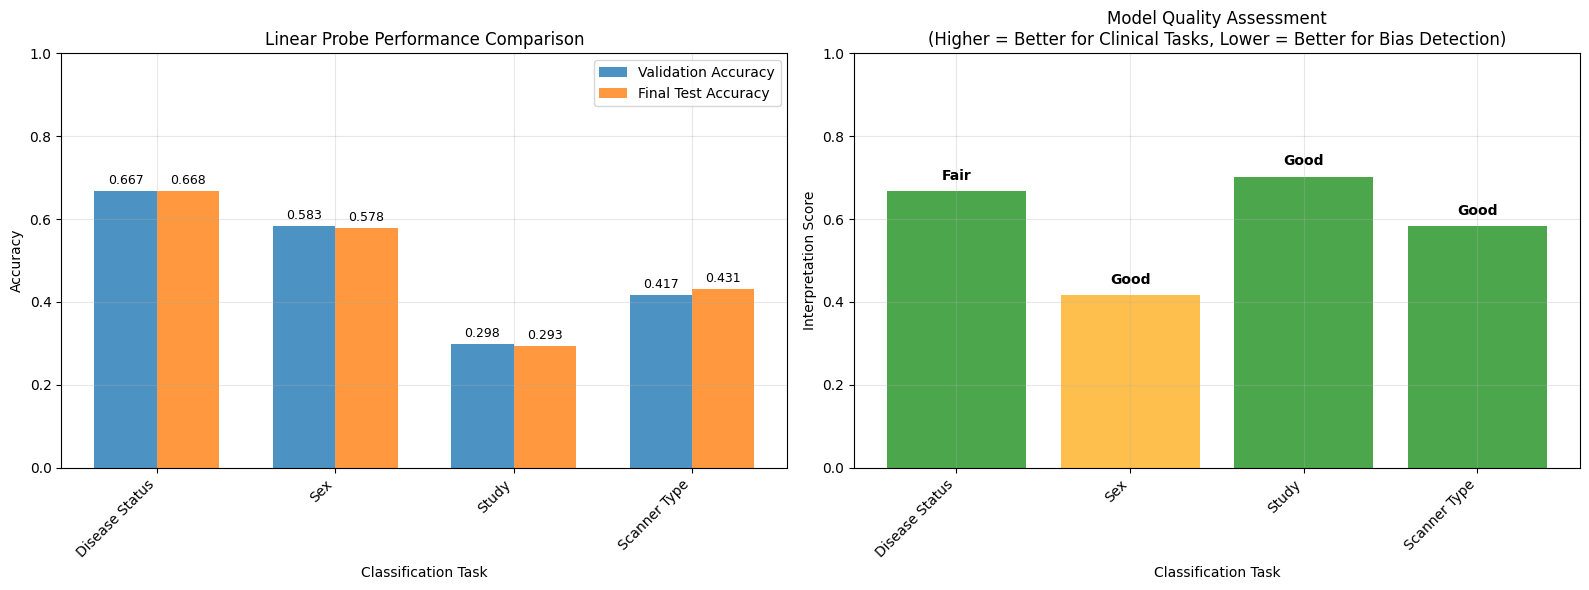


INTERPRETATION AND RECOMMENDATIONS

1. DISEASE STATUS CLASSIFICATION: 0.6667
   ⚠️  FAIR/POOR: Model may need more training or different architecture

2. SEX CLASSIFICATION: 0.5833
   ✅ GOOD: No significant gender bias detected

3. STUDY CLASSIFICATION: 0.2976
   ✅ GOOD: Good generalization across different studies

4. SCANNER TYPE CLASSIFICATION: 0.4167
   ✅ GOOD: Good generalization across different scanners

OVERALL ASSESSMENT
The linear probe evaluation provides insights into what information is encoded in the embeddings:
• High disease accuracy indicates clinical relevance
• Low sex/study/scanner accuracy indicates good generalization
• Early stopping prevents overfitting during probe training
• This evaluation helps assess the quality of the backbone model


In [13]:
# Comprehensive Results Summary
print("\n" + "=" * 100)
print("COMPREHENSIVE LINEAR PROBE RESULTS SUMMARY")
print("=" * 100)

# Create comparison table
import pandas as pd

results_df = pd.DataFrame(
    {
        "Task": ["Disease Status", "Sex", "Study", "Scanner Type"],
        "Validation Accuracy": [
            probe_results["Disease Status"],
            probe_results["Sex"],
            probe_results["Study"],
            probe_results["Scanner Type"],
        ],
        "Final Test Accuracy": [
            test_results["Disease Status"],
            test_results["Sex"],
            test_results["Study"],
            test_results["Scanner Type"],
        ],
        "Task Type": ["Binary", "Binary", "Multi-class", "Multi-class"],
        "Classes": [2, 2, num_studies, num_scanners],
    }
)

print("\nRESULTS TABLE:")
print(results_df.to_string(index=False, float_format="%.4f"))

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot comparing validation and test accuracies
tasks = results_df["Task"]
val_accs = results_df["Validation Accuracy"]
test_accs = results_df["Final Test Accuracy"]

x = np.arange(len(tasks))
width = 0.35

bars1 = ax1.bar(x - width / 2, val_accs, width, label="Validation Accuracy", alpha=0.8)
bars2 = ax1.bar(x + width / 2, test_accs, width, label="Final Test Accuracy", alpha=0.8)

ax1.set_xlabel("Classification Task")
ax1.set_ylabel("Accuracy")
ax1.set_title("Linear Probe Performance Comparison")
ax1.set_xticks(x)
ax1.set_xticklabels(tasks, rotation=45, ha="right")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.01,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

# Performance interpretation
interpretation_scores = []
interpretation_labels = []

for task in tasks:
    val_acc = val_accs[tasks == task].iloc[0]
    if task == "Disease Status":
        # High accuracy is good for disease classification
        score = val_acc
        label = "Good" if val_acc > 0.7 else "Fair" if val_acc > 0.6 else "Poor"
    elif task == "Sex":
        # Low accuracy is good (no gender bias)
        score = 1 - val_acc
        label = "Good" if val_acc < 0.6 else "Fair" if val_acc < 0.7 else "Concerning"
    else:
        # Low accuracy is good (no site/scanner bias)
        score = 1 - val_acc
        label = "Good" if val_acc < 0.5 else "Fair" if val_acc < 0.7 else "Concerning"

    interpretation_scores.append(score)
    interpretation_labels.append(label)

# Interpretation plot
colors = [
    "green" if score > 0.5 else "orange" if score > 0.3 else "red"
    for score in interpretation_scores
]
bars3 = ax2.bar(tasks, interpretation_scores, color=colors, alpha=0.7)
ax2.set_xlabel("Classification Task")
ax2.set_ylabel("Interpretation Score")
ax2.set_title(
    "Model Quality Assessment\n(Higher = Better for Clinical Tasks, Lower = Better for Bias Detection)"
)
ax2.set_xticklabels(tasks, rotation=45, ha="right")
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

# Add interpretation labels
for bar, label in zip(bars3, interpretation_labels):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.02,
        label,
        ha="center",
        va="bottom",
        fontweight="bold",
        fontsize=10,
    )

plt.tight_layout()
plt.show()

# Final interpretation
print("\n" + "=" * 100)
print("INTERPRETATION AND RECOMMENDATIONS")
print("=" * 100)

print(
    f"\n1. DISEASE STATUS CLASSIFICATION: {results_df[results_df['Task'] == 'Disease Status']['Validation Accuracy'].iloc[0]:.4f}"
)
if (
    results_df[results_df["Task"] == "Disease Status"]["Validation Accuracy"].iloc[0]
    > 0.7
):
    print("   ✅ GOOD: Model learned clinically relevant features")
else:
    print("   ⚠️  FAIR/POOR: Model may need more training or different architecture")

print(
    f"\n2. SEX CLASSIFICATION: {results_df[results_df['Task'] == 'Sex']['Validation Accuracy'].iloc[0]:.4f}"
)
if results_df[results_df["Task"] == "Sex"]["Validation Accuracy"].iloc[0] < 0.6:
    print("   ✅ GOOD: No significant gender bias detected")
else:
    print("   ⚠️  CONCERNING: Model may be biased toward gender")

print(
    f"\n3. STUDY CLASSIFICATION: {results_df[results_df['Task'] == 'Study']['Validation Accuracy'].iloc[0]:.4f}"
)
if results_df[results_df["Task"] == "Study"]["Validation Accuracy"].iloc[0] < 0.5:
    print("   ✅ GOOD: Good generalization across different studies")
else:
    print("   ⚠️  CONCERNING: Model may be biased toward specific studies")

print(
    f"\n4. SCANNER TYPE CLASSIFICATION: {results_df[results_df['Task'] == 'Scanner Type']['Validation Accuracy'].iloc[0]:.4f}"
)
if (
    results_df[results_df["Task"] == "Scanner Type"]["Validation Accuracy"].iloc[0]
    < 0.5
):
    print("   ✅ GOOD: Good generalization across different scanners")
else:
    print("   ⚠️  CONCERNING: Model may be biased toward specific scanners")

print("\n" + "=" * 100)
print("OVERALL ASSESSMENT")
print("=" * 100)
print(
    "The linear probe evaluation provides insights into what information is encoded in the embeddings:"
)
print("• High disease accuracy indicates clinical relevance")
print("• Low sex/study/scanner accuracy indicates good generalization")
print("• Early stopping prevents overfitting during probe training")
print("• This evaluation helps assess the quality of the backbone model")
print("=" * 100)
